## 목적

* 모델 사전학습

In [1]:
import os
import time
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle

%matplotlib inline

### 패키지 버전
텐서플로우(tf) == 2.1.0

In [2]:
print('tf',tf.__version__)

tf 2.1.0


## 데이터셋

In [3]:
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12894, 160, 160, 3) (12894,)
(500, 160, 160, 3) (500,)


## 모델 사전 학습

In [4]:
EPOCHS = 5
BATCH_SIZE = 2**7
MODEL_SAVE = False

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[160, 160, 3], include_top=False,weights='imagenet')

In [6]:
class Model(models.Model):
    def __init__(self,base_model):
        super(Model,self).__init__()
        self.base_model = base_model
        self.top_layer = models.Sequential([
            layers.Dense(10),
            layers.Activation(tf.nn.softmax),
        ])
        
    def call(self,inputs,training=False):
        x = self.base_model(inputs, training=training)
        x = layers.Flatten()(x)
        outputs = self.top_layer(x, training=training)
        return outputs

In [7]:
model = Model(base_model)

sce = losses.SparseCategoricalCrossentropy()
opt = optimizers.Adam(learning_rate=1e-4)

train_acc = metrics.SparseCategoricalAccuracy()
test_acc = metrics.SparseCategoricalAccuracy()

train_loss = metrics.Mean()
test_loss = metrics.Mean()

In [8]:
def train_step(inputs):
    X, y = inputs
    
    with tf.GradientTape() as t:
        y_pred = model(X)
        loss = sce(y, y_pred)
        
    grads = t.gradient(loss, model.trainable_variables)
    opt.apply_gradients(list(zip(grads,model.trainable_variables)))
    
    train_acc.update_state(y, y_pred)
    train_loss.update_state(loss)

def test_step(inputs):
    X, y = inputs
    
    y_pred = model(X)
    loss = sce(y, y_pred)
        
    test_acc.update_state(y, y_pred)
    test_loss.update_state(loss)

In [9]:
BUFFER_SIZE = len(X_train)

train_dataset = tf.data.Dataset\
                .from_tensor_slices((X_train,y_train))\
                .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_loss_list = []
train_acc_list = []

In [24]:
best_loss = sys.float_info.max

for e in range(EPOCHS):
    s = time.time()
    
    for x in train_dataset:
        train_step(x)
        
    if e % 1 == 0:
        print(f'{e+1}/{EPOCHS}\tacc = {train_acc.result()*100:.2f}%, loss = {train_loss.result():.8f}, {time.time() - s:.2f} sec/epoch')
        
    train_loss_list.append(train_loss.result())
    train_acc_list.append(train_acc.result())
    
    if best_loss > train_loss.result() and MODEL_SAVE:
        best_loss = train_loss.result()
        
        weights = model.get_weights()
        
        path = f'../model/model_20200507_{e}_{train_acc.result():.2f}_{train_loss.result():.4f}'

        with open(path,'wb') as f:
            pickle.dump(weights,f)
    
    train_loss.reset_states()
    train_acc.reset_states()

1/5	acc = 91.03%, loss = 0.29636291, 31.49 sec/epoch
2/5	acc = 97.19%, loss = 0.08645852, 32.09 sec/epoch
3/5	acc = 98.88%, loss = 0.03537539, 32.10 sec/epoch
4/5	acc = 99.15%, loss = 0.02458635, 30.95 sec/epoch
5/5	acc = 99.61%, loss = 0.01339888, 31.84 sec/epoch


## 모델 성능 테스트

In [25]:
test_dataset = tf.data.Dataset\
                .from_tensor_slices((X_test,y_test))\
                .batch(BATCH_SIZE)

In [26]:
test_acc.reset_states()
test_loss.reset_states()

for x in test_dataset:
    test_step(x)

print(f'acc = {test_acc.result().numpy()*100:.2f}%')
print(f'loss = {test_loss.result().numpy():.4f}')

acc = 96.60%
loss = 0.1927


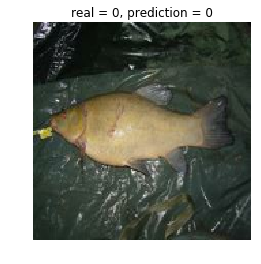

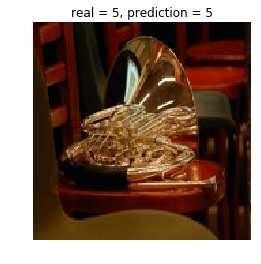

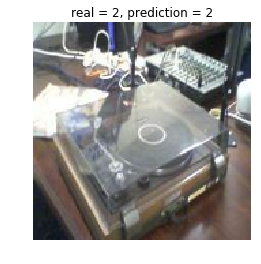

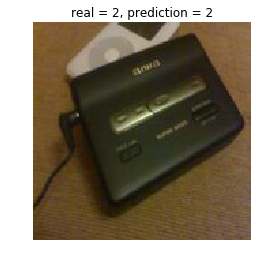

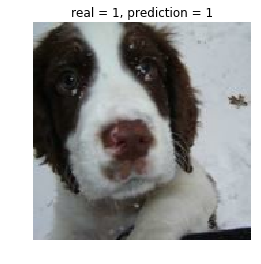

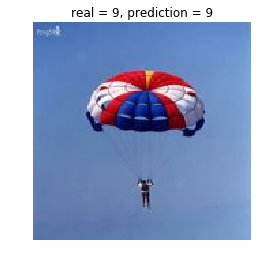

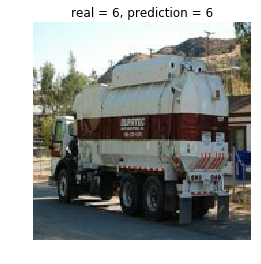

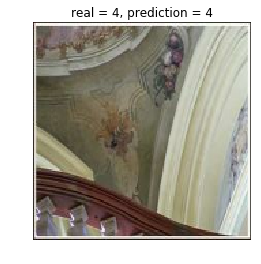

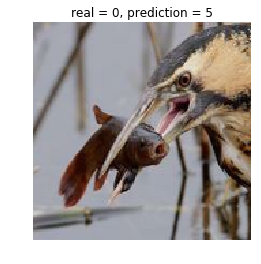

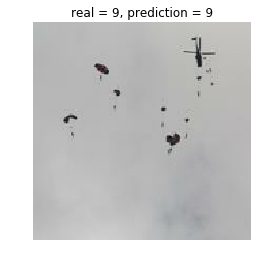

In [27]:
for _ in range(10):
    idx = np.random.randint(len(X_test))
    y_pred = model(X_test[idx:idx+1])
    
    plt.imshow(X_test[idx])
    plt.title(f'real = {int(y_test[idx])}, prediction = {np.argmax(y_pred)}')
    plt.axis('off')
    plt.show()